In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas_datareader.data as web

In [2]:
apple = web.DataReader('aapl'
                       , 'yahoo'
                       , start = '12/12/1980'
                      )
apple.shape

(10091, 6)

In [3]:
apple.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615


In [4]:
apple['Close_Shift1_DOwn'] = apple.Close.shift(1, fill_value = 0.0)
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn
Date,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513


In [5]:
# Function to find the max daily change in the direction of overall daily change 
def hl(h, l, o, c):
    if o - c > 0:
        return l-h
    else:
        return h-l

In [6]:
# Max daily change in the same direction fo daily change
apple['Max Daily Change'] = apple.apply(lambda x: hl(x[0], x[1], x[2], x[3]), axis=1)
apple.sample(10)

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change
Date,,,,,,,,
1985-10-03,0.069754,0.069196,0.069754,0.069196,48921600.0,0.054499,0.069754,-0.000558
2008-05-01,6.428571,6.245000,6.248571,6.428571,903576800.0,5.545612,6.212500,0.183571
1983-06-02,0.261161,0.257812,0.259487,0.261161,79430400.0,0.205689,0.259487,0.003348
2019-12-18,70.474998,69.779999,69.949997,69.934998,116028400.0,69.336212,70.102501,-0.695000
1985-04-19,0.102121,0.099888,0.102121,0.100446,96028800.0,0.079111,0.102121,-0.002232
1994-08-04,0.301339,0.295759,0.295759,0.296875,184755200.0,0.251582,0.295759,0.005580
2008-08-05,5.742857,5.529286,5.550714,5.737143,688371600.0,4.949151,5.472500,0.213571
1987-03-11,0.303571,0.295759,0.300223,0.295759,218467200.0,0.232939,0.297991,-0.007812
2007-05-29,4.102143,4.024643,4.087500,4.083929,645694000.0,3.523004,4.057857,-0.077500


In [7]:
# negative means the next day opened lower than the pervious day
apple['Interday Change'] = apple.apply(lambda x: x[2] - x[6], axis = 1)
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change
Date,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348


In [8]:
# Positive 'Close Adjusted Close' means overvalued price at close of day
apple['Close Adjusted Close'] = apple.apply(lambda x: x[3] - x[5], axis = 1)
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close
Date,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138,0.025839
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371,0.023943
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247


In [9]:
apple[(apple['Max Daily Change'] > 0) & (apple['Interday Change'] < 0)]

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close
Date,,,,,,,,,,
1986-03-17,0.116071,0.113281,0.116071,0.116071,118720000.0,0.091418,0.116629,0.002790,-0.000558,0.024654
1986-08-01,0.141741,0.138951,0.138951,0.140067,150080000.0,0.110316,0.139509,0.002790,-0.000558,0.029751
1986-08-12,0.153460,0.148996,0.148996,0.152902,244160000.0,0.120425,0.149554,0.004464,-0.000558,0.032477
1986-08-19,0.158482,0.154576,0.156808,0.157924,137782400.0,0.124381,0.157924,0.003906,-0.001116,0.033544
1986-08-20,0.162946,0.157366,0.157366,0.161830,171315200.0,0.127457,0.157924,0.005580,-0.000558,0.034373
...,...,...,...,...,...,...,...,...,...,...
2020-11-16,120.989998,118.150002,118.919998,120.300003,91183000.0,120.300003,119.260002,2.839996,-0.340004,0.000000
2020-11-19,119.059998,116.809998,117.589996,118.639999,74113000.0,118.639999,118.029999,2.250000,-0.440002,0.000000
2020-12-02,123.370003,120.889999,122.019997,123.080002,89004200.0,123.080002,122.720001,2.480003,-0.700005,0.000000


In [10]:
apple[apple['Open'] == apple['Close']]

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close
Date,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247
1980-12-19,0.126674,0.126116,0.126116,0.126116,48630400.0,0.099329,0.118862,0.000558,0.007254,0.026787
1980-12-22,0.132812,0.132254,0.132254,0.132254,37363200.0,0.104163,0.126116,0.000558,0.006138,0.028091
...,...,...,...,...,...,...,...,...,...,...
2014-07-01,23.517500,23.282499,23.379999,23.379999,152892000.0,21.101110,23.232500,0.235001,0.147499,2.278889
2015-07-28,30.977501,30.637501,30.844999,30.844999,134472400.0,28.326986,30.692499,0.340000,0.152500,2.518013
2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.944889,43.750000,0.420002,-0.162498,1.642612


In [11]:
apple['Open Close % Change'] = (apple['Close'] - apple['Open']) / apple['Open'] * 100
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close,Open Close % Change
Date,,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262,0.000000
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138,0.025839,-0.456625
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371,0.023943,-0.492609
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535,0.000000
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247,0.000000


In [12]:
apple['Open Close % Change'].describe()

count    10091.000000
mean        -0.010760
std          2.343740
min        -24.352329
25%         -1.162786
50%          0.000000
75%          1.087892
max         19.266055
Name: Open Close % Change, dtype: float64

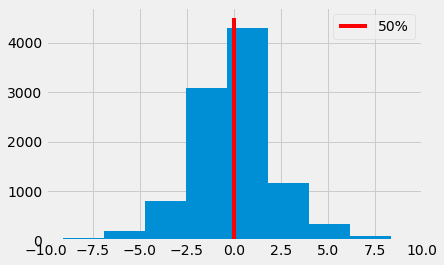

In [13]:
apple['Open Close % Change'].hist(bins=20)
plt.vlines(0, 0, 4500, colors='r', label = '50%')
plt.xlim(-10, 10)
plt.legend();

In [14]:
apple['Open Close % Change'].quantile([0.84])

0.84    1.83602
Name: Open Close % Change, dtype: float64

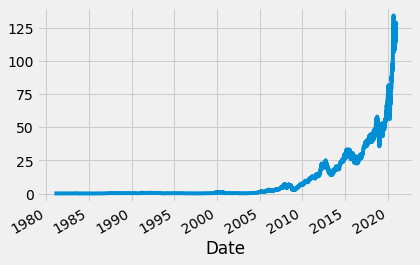

In [15]:
apple['Close'].plot();

In [16]:
def decision(p):
    if p > 1.5:
        return 1
    elif p < -0.75:
        return -1
    else:
        return 0

In [17]:
apple['Buy Hold Sell'] = apple.apply(lambda x: decision(x[10]), axis = 1)

In [18]:
apple.sample(10)

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close,Open Close % Change,Buy Hold Sell
Date,,,,,,,,,,,,
2008-05-27,6.658214,6.494286,6.526786,6.658214,789905200.0,5.743714,6.470357,0.163929,0.056429,0.914500,2.013675,1
1996-02-16,0.253348,0.245536,0.251116,0.245536,156441600.0,0.211812,0.250000,-0.007812,0.001116,0.033724,-2.222220,-1
2019-02-01,42.244999,41.482498,41.740002,41.630001,130672400.0,40.662605,41.610001,-0.762501,0.130001,0.967396,-0.263538,0
1990-08-30,0.334821,0.321429,0.332589,0.323661,122595200.0,0.263244,0.332589,-0.013393,0.000000,0.060417,-2.684571,-1
2010-04-21,9.294642,9.133214,9.242857,9.257857,982391200.0,7.986296,8.735357,0.161428,0.507500,1.271562,0.162291,0
1999-08-09,0.492746,0.484375,0.485212,0.486049,233284800.0,0.419291,0.483259,0.008371,0.001953,0.066758,0.172514,0
2012-08-13,22.500000,22.258928,22.263929,22.500000,278832400.0,19.492977,22.203571,0.241072,0.060358,3.007023,1.060328,0
1981-04-30,0.127790,0.126674,0.126674,0.126674,12611200.0,0.099768,0.124442,0.001116,0.002232,0.026906,0.000000,0
1998-02-12,0.173549,0.170201,0.170759,0.172991,203750400.0,0.149231,0.169643,0.003348,0.001116,0.023760,1.307185,0


In [19]:
# Min Max Normalization of Features
vol_max = apple['Volume'].max()
vol_min = apple['Volume'].min()
apple['Volume Norm'] = (apple['Volume'] - vol_min) / (vol_max - vol_min)

daily_max = apple['Max Daily Change'].max()
daily_min = apple['Max Daily Change'].min()
apple['Max Daily Change Norm'] = (apple['Max Daily Change'] - daily_min) / (daily_max - daily_min)

inter_max = apple['Interday Change'].max()
inter_min = apple['Interday Change'].min()
apple['Interday Change Norm'] = (apple['Interday Change'] - inter_min) / (inter_max - inter_min)

adj_max = apple['Close Adjusted Close'].max()
adj_min = apple['Close Adjusted Close'].min()
apple['Close Adjusted Close Norm'] = (apple['Close Adjusted Close'] - adj_min) / (adj_max - adj_min)

apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close,Open Close % Change,Buy Hold Sell,Volume Norm,Max Daily Change Norm,Interday Change Norm,Close Adjusted Close Norm
Date,,,,,,,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262,0.000000,0,0.063023,0.461562,0.581742,0.008135
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138,0.025839,-0.456625,0,0.023516,0.461515,0.573176,0.007711
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371,0.023943,-0.492609,0,0.014061,0.461515,0.573034,0.007145
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535,0.000000,0,0.011462,0.461562,0.573745,0.007321
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247,0.000000,0,0.009711,0.461562,0.573780,0.007534


In [20]:
apple['Buy Hold Sell Shift1 Down'] = apple['Buy Hold Sell'].shift(1, fill_value=0).astype(int)
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close,Open Close % Change,Buy Hold Sell,Volume Norm,Max Daily Change Norm,Interday Change Norm,Close Adjusted Close Norm,Buy Hold Sell Shift1 Down
Date,,,,,,,,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262,0.000000,0,0.063023,0.461562,0.581742,0.008135,0
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138,0.025839,-0.456625,0,0.023516,0.461515,0.573176,0.007711,0
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371,0.023943,-0.492609,0,0.014061,0.461515,0.573034,0.007145,0
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535,0.000000,0,0.011462,0.461562,0.573745,0.007321,0
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247,0.000000,0,0.009711,0.461562,0.573780,0.007534,0


In [21]:
# Select features
apple.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close',
       'Close_Shift1_DOwn', 'Max Daily Change', 'Interday Change',
       'Close Adjusted Close', 'Open Close % Change', 'Buy Hold Sell',
       'Volume Norm', 'Max Daily Change Norm', 'Interday Change Norm',
       'Close Adjusted Close Norm', 'Buy Hold Sell Shift1 Down'],
      dtype='object')

In [52]:
apple_ = apple[['Volume Norm'
                , 'Max Daily Change Norm'
                , 'Interday Change Norm'
                , 'Close Adjusted Close Norm'
                , 'Buy Hold Sell Shift1 Down'
               ]
              ]

In [53]:
apple_.head()

,Volume Norm,Max Daily Change Norm,Interday Change Norm,Close Adjusted Close Norm,Buy Hold Sell Shift1 Down
Date,,,,,
1980-12-12,0.063023,0.461562,0.581742,0.008135,0
1980-12-15,0.023516,0.461515,0.573176,0.007711,0
1980-12-16,0.014061,0.461515,0.573034,0.007145,0
1980-12-17,0.011462,0.461562,0.573745,0.007321,0
1980-12-18,0.009711,0.461562,0.573780,0.007534,0


In [54]:
targets = list(apple_['Buy Hold Sell Shift1 Down'].value_counts().index)
targets_counts = list(apple_['Buy Hold Sell Shift1 Down'].value_counts().values)

In [55]:
targets

[0, -1, 1]

In [56]:
targets_counts

[4887, 3264, 1940]

In [57]:
from sklearn.utils import resample

In [59]:
X_major = apple_[apple_['Buy Hold Sell Shift1 Down'] == 0]
X1_minor = apple_[apple_['Buy Hold Sell Shift1 Down'] == -1]
X2_minor = apple_[apple_['Buy Hold Sell Shift1 Down'] == 1]

X1_minor_upsampled = resample(X1_minor
                              , replace = True
                              , n_samples = targets_counts[0]
                              , random_state = 42
                             )

X2_minor_upsampled = resample(X2_minor
                              , replace = True
                              , n_samples = targets_counts[0]
                              , random_state = 42
                             )

apple_upsampled = pd.concat([X_major, X1_minor_upsampled, X2_minor_upsampled])

In [60]:
apple_upsampled['Buy Hold Sell Shift1 Down'].value_counts()

-1    4887
 1    4887
 0    4887
Name: Buy Hold Sell Shift1 Down, dtype: int64

In [61]:
apple_upsampled = apple_upsampled.sample(frac = 1).reset_index(drop=True)
apple_upsampled.head()

,Volume Norm,Max Daily Change Norm,Interday Change Norm,Close Adjusted Close Norm,Buy Hold Sell Shift1 Down
0,0.081466,0.460131,0.574278,0.024289,-1
1,0.023252,0.462101,0.573709,0.021741,0
2,0.017061,0.414040,0.562739,0.297215,0
3,0.009339,0.460882,0.573425,0.019439,-1
4,0.020965,0.462008,0.573140,0.025513,0


In [98]:
from sklearn.model_selection import train_test_split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(apple_upsampled.drop('Buy Hold Sell Shift1 Down', axis=1)
                                                    , apple_upsampled['Buy Hold Sell Shift1 Down']
                                                    , test_size = 0.1
                                                    , random_state = 42
                                                   )

In [100]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
from sklearn import metrics
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')

Accuracy: 0.792774369461486


In [101]:
from sklearn.model_selection import cross_val_score
cval = cross_val_score(rfc
                       , apple_upsampled.drop('Buy Hold Sell Shift1 Down', axis=1)
                       , apple_upsampled['Buy Hold Sell Shift1 Down']
                       , scoring = 'accuracy'
                       , cv = 7
                      )
print(f'7 Fold Cross-Validation Score for First RF Model: {np.mean(cval)}')

7 Fold Cross-Validation Score for First RF Model: 0.7922381776256809


In [102]:
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

In [109]:
y_probs = rfc.predict_proba(X_test)[:, 1]
y_probs

array([0.12, 0.06, 0.01, ..., 0.22, 0.17, 0.04])

In [112]:
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

In [113]:
# roc_score1 = roc_auc_score(y_test
#                            , y_probs
#                            , multi_class = 'ovr'
#                            , average = 'macro'
#                           )
# roc_score1

In [78]:
rfc.feature_importances_

array([0.29533872, 0.21823586, 0.19215287, 0.29427256])

In [86]:
feature_imp = pd.Series(rfc.feature_importances_, index=apple_upsampled.columns[:4]).sort_values(ascending=False)
feature_imp

Volume Norm                  0.295339
Close Adjusted Close Norm    0.294273
Max Daily Change Norm        0.218236
Interday Change Norm         0.192153
dtype: float64

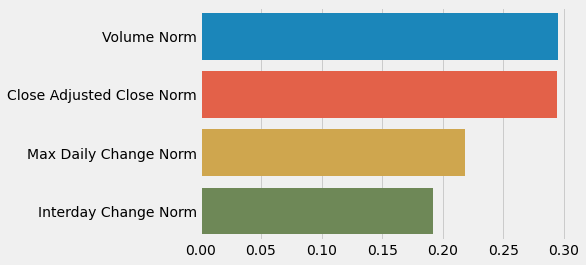

In [84]:
import seaborn as sns
sns.barplot(x=feature_imp
            , y=feature_imp.index
           );

In [88]:
# Drop 'Interday Change Norm' Column
apple_upsampled_reduced = apple_upsampled.drop('Interday Change Norm', axis =1)
apple_upsampled_reduced.head()

,Volume Norm,Max Daily Change Norm,Close Adjusted Close Norm,Buy Hold Sell Shift1 Down
0,0.081466,0.460131,0.024289,-1
1,0.023252,0.462101,0.021741,0
2,0.017061,0.414040,0.297215,0
3,0.009339,0.460882,0.019439,-1
4,0.020965,0.462008,0.025513,0


In [89]:
X_train, X_test, y_train, y_test = train_test_split(apple_upsampled_reduced.drop('Buy Hold Sell Shift1 Down', axis=1)
                                                    , apple_upsampled_reduced['Buy Hold Sell Shift1 Down']
                                                    , test_size = 0.1
                                                    , random_state = 42
                                                   )

In [90]:
# rfcr for Random Forest Classifier Reduced
rfcr = RandomForestClassifier(n_estimators = 100)
rfcr.fit(X_train, y_train)
y_pred = rfcr.predict(X_test)
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')

Accuracy: 0.8016359918200409


In [93]:
cvalr = cross_val_score(rfcr
                       , apple_upsampled.drop('Buy Hold Sell Shift1 Down', axis=1)
                       , apple_upsampled['Buy Hold Sell Shift1 Down']
                       , scoring = 'accuracy'
                       , cv = 7
                      )
print(f'7 Fold Cross-Validation Score for Reduced RF Model: {np.mean(cvalr)}')

7 Fold Cross-Validation Score for Reduced RF Model: 0.7929885885052709
